<a href="https://colab.research.google.com/github/EnricoMiche1210760/toxic_comments_filter/blob/main/src/progetto_toxic_comments_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project: Toxic Comment Filter

Costruire un modello in grado di filtrare i commenti degli utenti in base al grado di dannosità del linguaggio:
1. Preprocessare il testo eliminando l'insieme di token che non danno contributo significativo a livello semantico
2. Trasformare il corpus testuale in sequenze
3. Costruire un modello di Deep Learning comprendente dei layer ricorrenti per un task di classificazione multilabel
4. In prediction time, il modello deve ritornare un vettore contenente un 1 o uno 0 in corrispondenza di ogni label presente nel dataset (toxic,	severe_toxic,	obscene,	threat,	insult,	identity_hate). In questo modo, un commento non dannoso sarà classificato da un vettore di soli 0 [0,0,0,0,0,0]. Al contrario, un commento pericoloso presenterà almeno un 1 tra le 6 labels.

In [145]:
import pandas as pd
import nltk
import spacy
import numpy as np
import os
import warnings
import tensorflow as tf

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


COLAB = False
if "google.colab" in str(get_ipython()):
    COLAB = True
    print('Running on CoLab')

In [146]:
if COLAB == True:
    BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
    storage_folder = "./"
else:
    BASE_URL = "../data/"
    storage_folder = BASE_URL
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")

In [147]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [148]:
df[df['sum_injurious']==2]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
51,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0,2
58,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0,2
79,Hi! I am back again!\nLast warning!\nStop undo...,1,0,0,1,0,0,2
86,"Would you both shut up, you don't run wikipedi...",1,0,0,0,1,0,2
168,"You should be fired, you're a moronic wimp who...",1,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...
159253,what do you mean \n\nwhy don't you keep your n...,1,0,1,0,0,0,2
159334,"Horse's ass \n\nSeriously, dude, what's that h...",1,0,1,0,0,0,2
159449,I think he is a gay fag!!!,1,0,0,0,0,1,2
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,2


In [149]:
len(df)

159571

In [150]:
df_text = np.array(df['comment_text'])
type(df_text)


try:
    nlp = spacy.load('en_core_web_sm')
except:
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')
try:
    eng_stopwords = nltk.corpus.stopwords.words('english')
except:
    nltk.download('stopwords')
    eng_stopwords = nltk.corpus.stopwords.words('english')
try:
    _ = nltk.tokenize.word_tokenize('test')
except:
    nltk.download('punkt')

def preprocess_text_and_store(text, doc_store=None, store=False):
    preprocessed_text = np.empty(len(text), dtype=object)
    if doc_store is None or doc_store not in os.listdir(storage_folder):
        counter = 0
        for i in range(len(text)):
            process_words = []
            text[i] = text[i].replace('\d', ' ')
            for word in nltk.word_tokenize(nlp(text[i].lower()).text):
                if word.isalpha() and word not in eng_stopwords:
                    process_words.append(word)
            preprocessed_text[counter] = ' '.join(process_words)
            counter += 1
    else:
        preprocessed_text = np.array(pd.read_csv(storage_folder+doc_store)['comment_text'])
    if store and not COLAB:
        pd.DataFrame(data = {"comment_text":preprocessed_text}).to_csv(BASE_URL+doc_store)

    return preprocessed_text

preprocessed_text= preprocess_text_and_store(df_text, doc_store="preprocessed_text.csv", store=True)


numpy.ndarray

In [151]:
df_text[0]
preprocessed_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

'explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired'

In [152]:
df = df.drop(columns=['comment_text'])

In [153]:
df.head(5)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0


In [154]:
df['sum_injurious'].unique()

array([0, 4, 1, 3, 2, 5, 6])

In [155]:
import matplotlib.pyplot as plt

def show_number(plot, barplot):
    for i in range(len(barplot)):
        height = barplot[i].get_height()
        plot.text(barplot[i].get_x() + barplot[i].get_width()/2, height, height, ha='center', va='bottom')

def plot_bar(columns, rows, figsize=(8,5), title:str=None, xlabel:str=None, ylabel:str=None, color='blue', xticks_settings=None, yticks_settings=None):
    plt.figure(figsize=figsize)
    barplot = plt.bar(columns, rows, color=color)
    plt.yticks(**yticks_settings)
    plt.xticks(**xticks_settings)
    if title is not None:
        plt.title(title, fontsize=15)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=10)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=10)
    show_number(plt, barplot)
    plt.show();


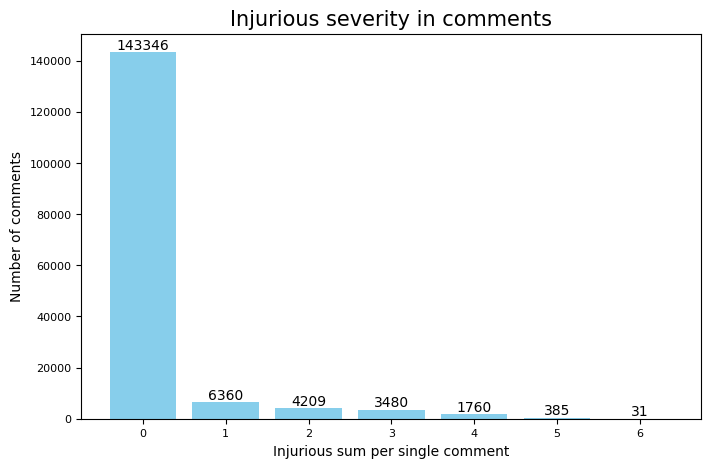

In [156]:
col_names = np.sort(df['sum_injurious'].unique())
comments_per_injurious = df['sum_injurious'].value_counts()

plot_bar(col_names, comments_per_injurious, title='Injurious severity in comments', \
         xlabel='Injurious sum per single comment', ylabel='Number of comments', color='skyblue', \
            xticks_settings={'fontsize':8}, yticks_settings={'fontsize':8})



In [157]:
injurious = df.drop(columns=['sum_injurious'])
non_injurious = pd.Series(data=comments_per_injurious[0], index=["none"])
injurious_type_sum = pd.concat([injurious.sum(axis=0), non_injurious]).sort_values(ascending=False)
injurious_type_sum

none             143346
toxic             15294
obscene            8449
insult             7877
severe_toxic       1595
identity_hate      1405
threat              478
dtype: int64

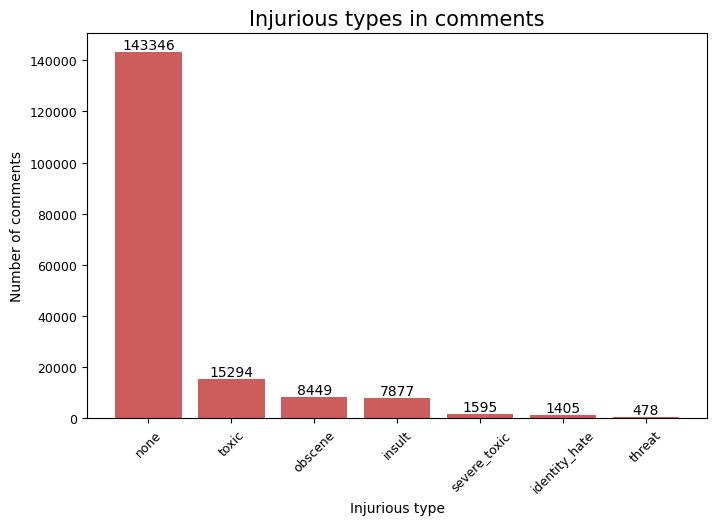

In [158]:
plot_bar(injurious_type_sum.index, injurious_type_sum, title='Injurious types in comments', \
         xlabel='Injurious type', ylabel='Number of comments', color='indianred', \
            xticks_settings={'rotation':45, 'fontsize':9}, yticks_settings={'fontsize':9})

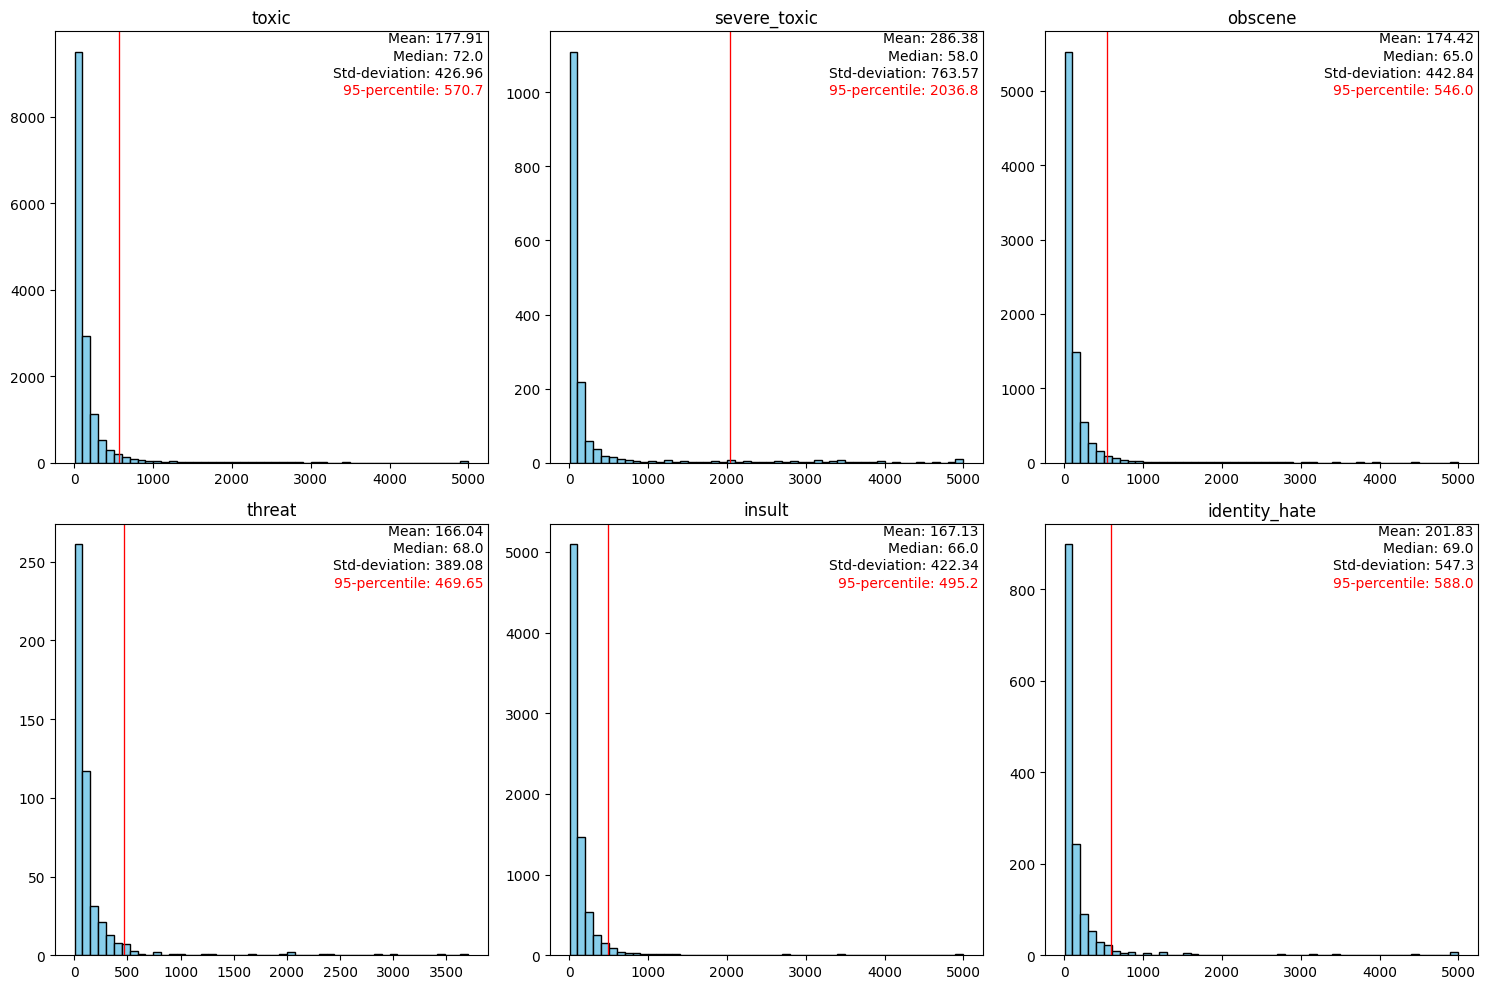

In [159]:
axes = []
fig, axes = plt.subplots(2, 3, figsize=(15,10))

len_sentences = np.array([len(str(sentence)) for sentence in preprocessed_text])

for i, col in enumerate(injurious.columns):
    len_sentences_col = len_sentences[df[df[col] == 1].index]
    ax = axes[i//3, i%3]
    ax.hist(len_sentences_col, bins=50, color='skyblue')
    ax.set_title(col)
    ax.text(.99, 1, f"Mean: {round(len_sentences_col.mean(), 2)}", transform=ax.transAxes, ha='right', va='top')
    ax.text(.99, .96, f"Median: {round(np.median(len_sentences_col), 2)}", transform=ax.transAxes, ha='right', va='top')
    ax.text(.99, .92, f"Std-deviation: {round(len_sentences_col.std(), 2)}", transform=ax.transAxes, ha='right', va='top')
    ax.text(.99, .88, f"95-percentile: {round(np.percentile(len_sentences_col, 95), 2)}", transform=ax.transAxes, ha='right', va='top', color='red')
    ax.axvline(x=np.percentile(len_sentences_col, 95), color='red', linewidth=.95)

fig.title("Titolo TEST")
fig.tight_layout()
plt.show();


In [160]:
injurious[0:10]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,1,1,1,0,1,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


In [161]:
from sklearn.model_selection import train_test_split

def train_test_val_split(data, labels=None, test_size=0.2, val_size=0.1, random_state=42):
    if labels is None:
        data, labels = data
    corpus, X_test, train_labels, y_test = train_test_split(data, labels, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(corpus, train_labels, test_size=val_size/(1-test_size), random_state=random_state)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_val = np.array(y_val)

    return X_train.astype(str).tolist(), X_test.astype(str).tolist(), X_val.astype(str).tolist(), y_train, y_test, y_val

X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(preprocessed_text, labels=injurious, test_size=0.3, val_size=0.2)


X_train[0:3]
y_train[0:3]

['diabetes received haldol years recently come diabetes initialy recieved haldol suposotories county hospital calm initial dose stop screaming complaining treatment hands hospital workers another dose administered haldol nothing proports think logically want sureal imaginations whenever bugs bad haldol stop illogicall creative wish psychobable dumb language get angry speak shrinks wish professionals would find usefull way contribute society trying modify people different behavior',
 'administrator hi wondering could help tried create new page one minute administrator deleted challennged basically said two lines long article proceeded threaten blocked complain',
 'also apparently allowed interwiki links 竜龙']

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [162]:
from tensorflow.keras.preprocessing.text import Tokenizer

type(X_train)

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train)

tokenizer.word_counts


list

OrderedDict([('diabetes', 8),
             ('received', 435),
             ('haldol', 4),
             ('years', 2356),
             ('recently', 878),
             ('come', 2326),
             ('initialy', 2),
             ('recieved', 39),
             ('suposotories', 1),
             ('county', 303),
             ('hospital', 109),
             ('calm', 124),
             ('initial', 203),
             ('dose', 30),
             ('stop', 3595),
             ('screaming', 42),
             ('complaining', 104),
             ('treatment', 243),
             ('hands', 232),
             ('workers', 130),
             ('another', 3327),
             ('administered', 21),
             ('nothing', 2591),
             ('proports', 1),
             ('think', 10016),
             ('logically', 45),
             ('want', 5794),
             ('sureal', 1),
             ('imaginations', 6),
             ('whenever', 175),
             ('bugs', 70),
             ('bad', 1843),
             ('il

In [163]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)
X_val   = tokenizer.texts_to_sequences(X_val)

vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size: ", vocab_size)

Vocabulary size:  106060


In [164]:
X_train[0]

[147,
 514,
 149,
 78,
 84,
 127,
 11,
 27,
 217,
 78,
 359,
 236,
 21,
 705,
 359,
 5,
 54,
 32,
 710,
 141,
 13,
 150,
 707]

In [165]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = len(max(X_train, key=len))
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)

X_train[0:5]
X_train.shape
y_train.shape



array([[147, 514, 149, ...,   0,   0,   0],
       [410,  75,  24, ...,   0,   0,   0],
       [ 10, 671, 552, ...,   0,   0,   0],
       [ 96, 325,  35, ...,   0,   0,   0],
       [713, 459, 293, ...,   0,   0,   0]], dtype=int32)

(79784, 1250)

(79784, 6)

In [166]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.backend import clear_session

def LSTM_simple_model(vocab_size, maxlen, dense_units=1, activation='softmax'):
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim=128, input_length=maxlen))
    model.add(Dropout(0.75)) #avoid overfitting
    model.add(LSTM(units=128, dropout=0.35, recurrent_dropout=0.2))
    model.add(Dense(dense_units, activation=activation))
    return model

class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if logs['val_accuracy'] > 0.97 and epoch-1 > 3:
            self.model.stop_training = True
            print('\nStop training at epoch:', epoch+1)

class OutputManager(tf.keras.callbacks.Callback):
    def on_train_end(self, *args, **kwargs):
        print('args:', args)
        print('kwargs:', kwargs)
#        if logs['val_accuracy'] > 0.97 and epoch > 3:
#            self.model.stop_training = True
#            print('Stop training at epoch:', epoch)
#on_train_end --> vedere se posso trasformare l'output in 0-1. e cosa comporta.

In [167]:
clear_session()
early_stopping = EarlyStopping()
base_model = LSTM_simple_model(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')
base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 128)         13575680  
                                                                 
 dropout (Dropout)           (None, 1250, 128)         0         
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 13708038 (52.29 MB)
Trainable params: 13708038 (52.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [169]:
model_history = base_model.fit(X_train, y_train,
                    epochs=10, batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/10
 193/1247 [===>..........................] - ETA: 23:23 - loss: 0.1599 - accuracy: 0.9062

In [26]:
model_history.history

{'loss': [0.14977611601352692,
  0.14033855497837067,
  0.14032115042209625,
  0.14041727781295776,
  0.14032965898513794],
 'accuracy': [0.9487528800964355,
  0.9938428401947021,
  0.9938585162162781,
  0.9938585162162781,
  0.9938585162162781],
 'val_loss': [0.14134879410266876,
  0.1412486881017685,
  0.14136727154254913,
  0.14121878147125244,
  0.1411435902118683],
 'val_accuracy': [0.9948362112045288,
  0.9948362112045288,
  0.9948362112045288,
  0.9948362112045288,
  0.9948362112045288]}

In [27]:
base_model.evaluate(X_test, y_test)

1746/1746 [==============================] - 198s 113ms/step - loss: 0.1424 - accuracy: 0.9940


[0.14241914451122284, 0.9940376281738281]

In [34]:
y_pred = base_model.predict(X_test)


#y_pred[i for i in range(len(y_pred)) if y_pred[i] != y_test[i] ]

1746/1746 [==============================] - 245s 140ms/step


In [35]:
for i in range(len(y_pred)):
    for j in range(len(y_pred[i])):
        y_pred[i][j] = 1 if y_pred[i][j] > 0.5 else 0

In [40]:
y_pred[0:50]
y_test[0:50]

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0.

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
 

## RNN with GRU layer

In [48]:
#RNN model with GRU layer and 4 hidden layers
from tensorflow.keras.layers import GRU, SimpleRNN, Dropout

clear_session()
rnn_gru_model = Sequential()
rnn_gru_model.add(Embedding(input_dim = vocab_size, output_dim=50, input_length=maxlen))
rnn_gru_model.add(GRU(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_gru_model.add(SimpleRNN(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_gru_model.add(Dense(32, activation='relu'))
rnn_gru_model.add(Dropout(0.2))
rnn_gru_model.add(Dense(len(y_train[0]), activation='softmax'))


rnn_gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn_gru_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 50)          6426300   
                                                                 
 gru (GRU)                   (None, 1250, 64)          22272     
                                                                 
 simple_rnn (SimpleRNN)      (None, 1250, 64)          8256      
                                                                 
 dense (Dense)               (None, 1250, 32)          2080      
                                                                 
 dropout (Dropout)           (None, 1250, 32)          0         
                                                                 
 dense_1 (Dense)             (None, 1250, 6)           198       
                                                                 
Total params: 6459106 (24.64 MB)
Trainable params: 64591

In [49]:
history_rnn_gru = rnn_gru_model.fit(X_train, y_train,
                    epochs=5, batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])


Epoch 1/5


ValueError: in user code:

    File "/home/enrico/Machine_learning/toxic_comments_filter/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/enrico/Machine_learning/toxic_comments_filter/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/enrico/Machine_learning/toxic_comments_filter/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/enrico/Machine_learning/toxic_comments_filter/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/enrico/Machine_learning/toxic_comments_filter/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/home/enrico/Machine_learning/toxic_comments_filter/venv/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/enrico/Machine_learning/toxic_comments_filter/venv/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/enrico/Machine_learning/toxic_comments_filter/venv/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/enrico/Machine_learning/toxic_comments_filter/venv/lib/python3.11/site-packages/keras/src/losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/home/enrico/Machine_learning/toxic_comments_filter/venv/lib/python3.11/site-packages/keras/src/backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 1250, 6) vs (None, 6)).


In [ ]:
rnn_gru_model.evaluate(X_test, y_test)

## Model with LSTM and Convolutional layer

In [ ]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

clear_session()
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim = vocab_size, output_dim=50, input_length=maxlen))
cnn_model.add(LSTM(units=50, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(len(y_train[0]), activation='softmax'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()


In [ ]:
history_cnn = cnn_model.fit(X_train, y_train,
                    epochs=5, batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])